# Kalman Filter for LUNA Modelling

## Explanation

In order to predict drop out, we can start by estimating an underlying latent variable ("intent to drop out"). My Understanding is, that this is mostly measured by the PANNP (etc) items. We can map these items into a latent space using the loadings found via CFA. With these, we can then measure and predict the "intent to drop out".

### Assumption: The loadings do infact measure this latent factor! We need to check this!

## Usage

See below for an example. The model at this point only runs on a per-person basis. 

## Next steps

1. Get this running on real data
2. Deploy
3. We can probably extend this into a type of multi-level model, by passing all students in a class, with a given covariance structure.


## Disclaimer: 
<span style="color:red">

There are likely some pretty big errors in here that lead to good performance. Either some mega reduction of noise (or lack of), or something else... I'm not sure... but im suspicious that this works so well!</span>

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
matplotlib.rcParams['figure.figsize'] = (15, 7)

In [15]:
def kalman_filter(X, A, H, Q, R, initial_state, initial_covariance):
    """
    Kalman filter implementation for estimating a single latent state.

    Parameters:
    - X: Input matrix of observations (shape: (3, T))
    - A: State transition matrix (shape: (1, 1))
    - H: Observation matrix (shape: (1, 3))
    - Q: Process noise covariance matrix (shape: (1, 1))
    - R: Observation noise covariance matrix (shape: (3, 3))
    - initial_state: Initial state estimate (shape: (1, 1))
    - initial_covariance: Initial state covariance matrix (shape: (1, 1))

    Returns:
    - state_estimates: Array of estimated latent states (shape: (1, T))
    - state_covariances: Array of state covariance matrices (shape: (1, 1, T))
    """

    T = X.shape[1]

    state_estimates = np.zeros((1, T))
    state_covariances = np.zeros((1, 1, T))

    # Initialization
    state_estimate = initial_state
    state_covariance = initial_covariance

    for t in range(T):
        # Prediction Step
        state_estimate_pred = A @ state_estimate
        state_covariance_pred = A @ state_covariance @ A.T + Q

        # Update Step
        observation_residual = X[:, t] - state_estimate_pred @ H
        observation_covariance = H.T @ state_covariance_pred @ H + R
        kalman_gain = state_covariance_pred @ H @ np.linalg.inv(observation_covariance)
        state_estimate = state_estimate_pred + kalman_gain @ observation_residual.T
        state_covariance = (np.eye(1) - kalman_gain @ H.T) @ state_covariance_pred

        # Save results
        state_estimates[:, t] = state_estimate.flatten()
        state_covariances[:, :, t] = state_covariance

    return state_estimates.reshape(-1), state_covariances



## Example Usage

We define the number of Time points (T) we want to simulate (this is not at all important)

Then, we define the different matrices required:

    A: State Transition matrix (read more about this)
    H: The observation matrix (factor loadings)
    Q: Variance of the latent factor (need to define this based on the data - unsure how)
    R: Observation noise - covariance (need to learn this somewhere)
    initial_state: starting point of the state. We can assume 0, (no intent to drop out), but we can also assume this to be slightly above 0 (dependent on scale)
    initial_cov: covariance of the latent factor

From here, we simulate some data:

    true_state: some random walk (also works without random work, i.e. random noise)
    noise: some random noise to avoid measurement error free observations (latent * loading + noise = observed)
    X: combination of the above, and final data

Then, we just call the function and verify the results by plotting

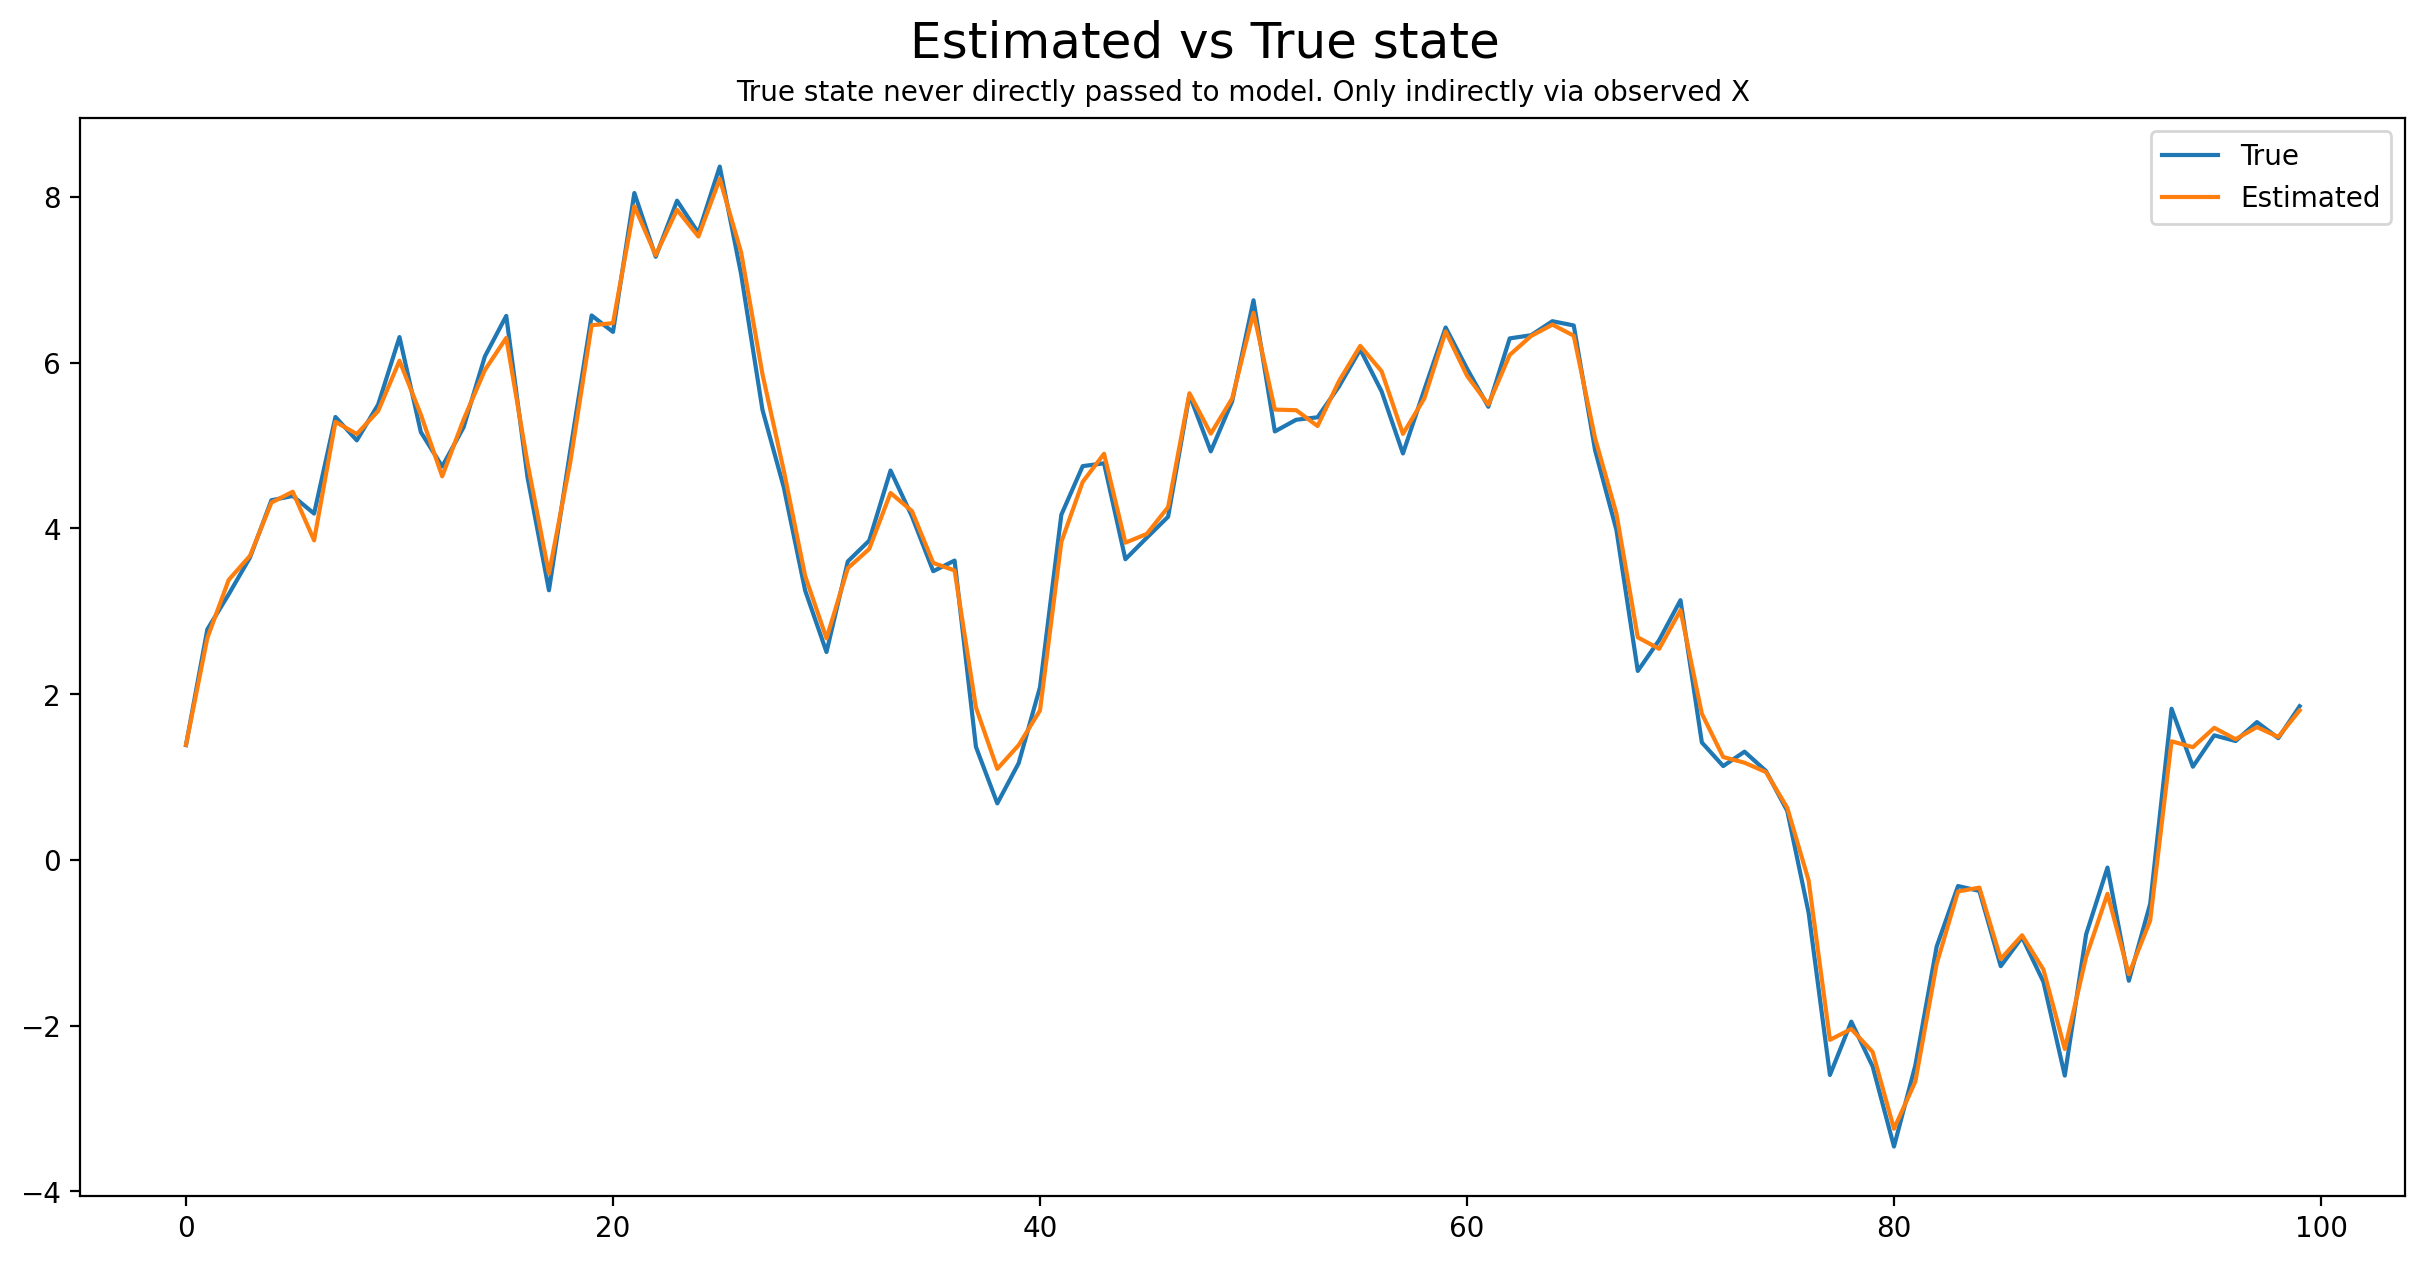

In [57]:
# Example Usage
T = 100  # Number of time points


# Define Kalman filter parameters
A = np.array([[1]])  # State transition matrix
H = np.array([[1, 3, -2]])  # Observation matrix
Q = np.array([[0.1]])  # Process noise covariance
R = np.array([[0.3, 0.1, 0],
              [0.1  ,   1, 0.2],
              [0  , 0.2, 0.2]])  # Observation noise covariance
initial_state = np.array([[0]])  # Initial state estimate
initial_covariance = np.array([[1]])  # Initial state covariance

true_state = np.cumsum(np.random.normal(loc=0.01, scale=1, size=T)).reshape(1,-1)
noise = np.random.multivariate_normal(mean=[0,0,0], cov = R, size=T).T
X = (true_state.T @ H).T + noise

# Run Kalman filter
state_estimates, state_covariances = kalman_filter(X, A, H, Q, R, initial_state, initial_covariance)

# Print the final estimated state
plt.plot(true_state.flatten(), label="True");
plt.plot(state_estimates, label="Estimated");
plt.suptitle("Estimated vs True state", y=.95, fontsize=18)
plt.title("True state never directly passed to model. Only indirectly via observed X", fontsize=10)
plt.legend();